# Project 1

## by Dion Ho


# Import Python Libraries

In [1]:
import numpy as np #Note that numpy-1.16.2 is needed
import math
import scipy as sc
import time
from scipy.integrate import quad
from scipy import linalg as la
from scipy import sparse
from math import pi
from math import factorial
from matplotlib import pyplot as plt

In [2]:
def rangeE(start,end):
    return range(start,end+1)

## Problem 1

In [3]:
def L(xvals,kk,x):
    value = np.ones(x.size)
    n = xvals.size
    for ii in range(0,n):
        if ii != kk:
            value *= (x-xvals[ii])/(xvals[kk]-xvals[ii])
    return value
    
def p_Lagrange(xvals,yvals,x):
    n = yvals.size
    pLagrange = np.zeros(x.size)
    for kk in range(0,n):
        pLagrange += yvals[kk]*L(xvals,kk,x)
    return pLagrange

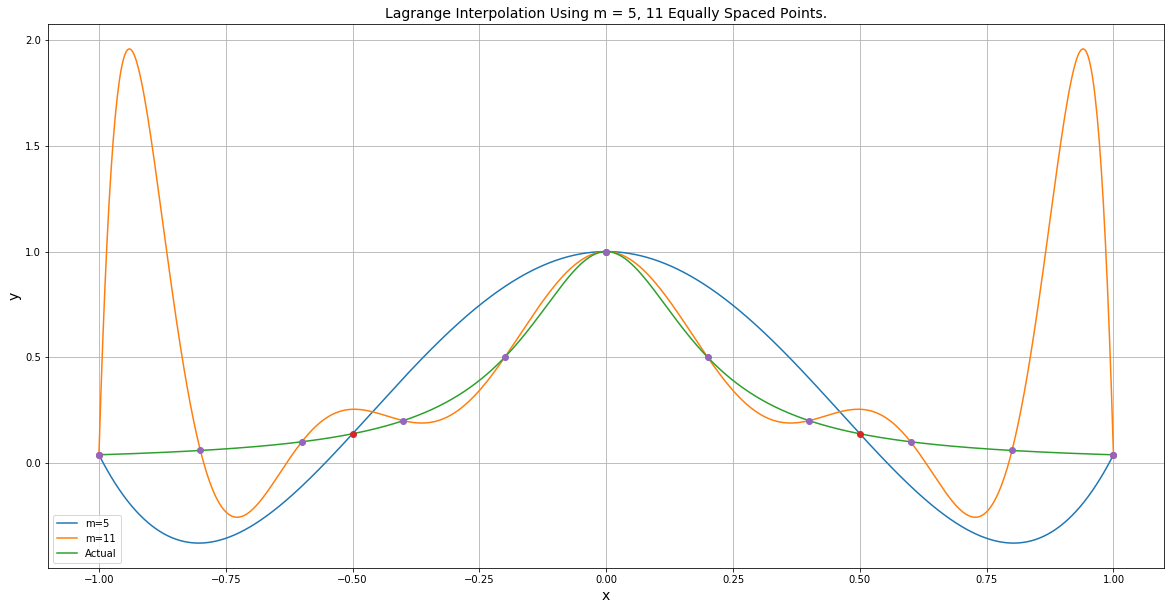

In [4]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,1000)

m = 5
x5vals = np.linspace(-1,1,m)
y5vals = f(x5vals)
m5 = p_Lagrange(x5vals,y5vals,x)

m = 11
x11vals = np.linspace(-1,1,m)
y11vals = f(x11vals)
m11 = p_Lagrange(x11vals,y11vals,x)

plt.figure(figsize=(20,10))
plt.title("Lagrange Interpolation Using m = 5, 11 Equally Spaced Points.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,m5)
plt.plot(x,m11)
plt.plot(x,f(x))
plt.plot(x5vals,y5vals, "o")
plt.plot(x11vals,y11vals, "o")
plt.legend(["m=5","m=11","Actual"])
plt.grid()

## Problem 2

In [5]:
def Bweights(xvals):
    n = xvals.size
    value = np.empty(n) #Initialising an array as np.empty is faster.
    C = (np.max(xvals) - np.min(xvals)) / 4
    shuffle = np.random.permutation(n-1)
    for ii in range(0,n):
        temp = (xvals[ii] - np.delete(xvals, ii)) / C
        temp = temp[shuffle]
        value[ii] = 1/np.product(temp)
    return value
    
def p_Barycentric(xvals,yvals,x):
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    n = yvals.size
    xsize = x.size
    numer = np.zeros(xsize)
    denom = np.zeros(xsize)
    w = Bweights(xvals)
    for jj in range(0,n):
        d = (x - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            x = np.delete(x,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    return ans

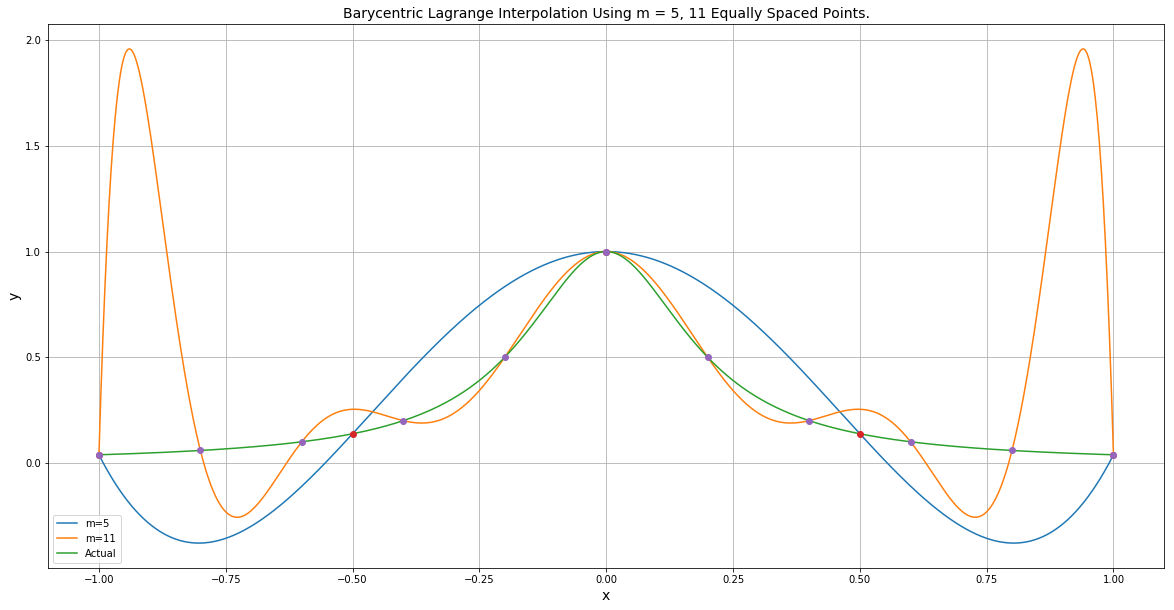

In [6]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,1000)

m = 5
x5vals = np.linspace(-1,1,m)
y5vals = f(x5vals)
m5 = p_Barycentric(x5vals,y5vals,x)

m = 11
x11vals = np.linspace(-1,1,m)
y11vals = f(x11vals)
m11 = p_Barycentric(x11vals,y11vals,x)

plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation Using m = 5, 11 Equally Spaced Points.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,m5)
plt.plot(x,m11)
plt.plot(x,f(x))
plt.plot(x5vals,y5vals, "o")
plt.plot(x11vals,y11vals, "o")
plt.legend(["m=5","m=11","Actual"])
plt.grid()

## Problem 3

In [7]:
def Bweights(xvals):
    n = xvals.size
    value = np.empty(n)
    C = (np.max(xvals) - np.min(xvals)) / 4
    shuffle = np.random.permutation(n-1)
    for ii in range(0,n):
        temp = (xvals[ii] - np.delete(xvals, ii)) / C
        temp = temp[shuffle]
        value[ii] = 1/np.product(temp)
    return value

def update_Bweights(old_xvals,old_weights,new_xvals):
    n = new_xvals.size
    for ii in range(0,n):
        newxval = new_xvals[ii]
        new_weight = 1/np.product(newxval - old_xvals)
        old_weights /= (old_xvals - newxval)
        old_weights = np.append(new_weight,old_weights)
        old_xvals = np.append(newxval,old_xvals)
    return old_weights

def p_Barycentric_reuse(xvals,yvals,x,old_data=np.array([[],[],[]])):
    #old_data must be in the format: np.array([[old_xvals],[old_yvals],[old_weights]])
    old_xvals = old_data[0,:]
    u1,u2,cup = np.intersect1d(old_xvals,xvals,assume_unique=True,return_indices=True) #Note that numpy-1.16.2 is needed for "return_indices" to work.
    xvals = np.delete(xvals,cup)
    yvals = np.delete(yvals,cup) #We remove any intersection to prevent divisions by zero when updating the weights.
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    yvals = np.append(yvals,old_data[1,:])
    n = yvals.size
    xsize = x.size
    numer = np.zeros(xsize)
    denom = np.zeros(xsize)
    w = update_Bweights(old_xvals,old_data[2,:],xvals)
    xvals = np.append(xvals,old_xvals)
    for jj in range(0,n):
        d = (x - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            x = np.delete(x,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    old_data = np.array([xvals,yvals,w])
    return ans, old_data

Data which can be re-used from m = 5
[[-1.         -0.5         0.          0.5         1.        ]
 [ 0.03846154  0.13793103  1.          0.13793103  0.03846154]
 [ 0.66666667 -2.66666667  4.         -2.66666667  0.66666667]]

Data which can be re-used from m = 9
[[-7.50000000e-01 -2.50000000e-01  2.50000000e-01  7.50000000e-01
  -1.00000000e+00 -5.00000000e-01  0.00000000e+00  5.00000000e-01
   1.00000000e+00]
 [ 6.63900415e-02  3.90243902e-01  3.90243902e-01  6.63900415e-02
   3.84615385e-02  1.37931034e-01  1.00000000e+00  1.37931034e-01
   3.84615385e-02]
 [-1.30031746e+01 -9.10222222e+01 -9.10222222e+01 -1.30031746e+01
   1.62539683e+00  4.55111111e+01  1.13777778e+02  4.55111111e+01
   1.62539683e+00]]


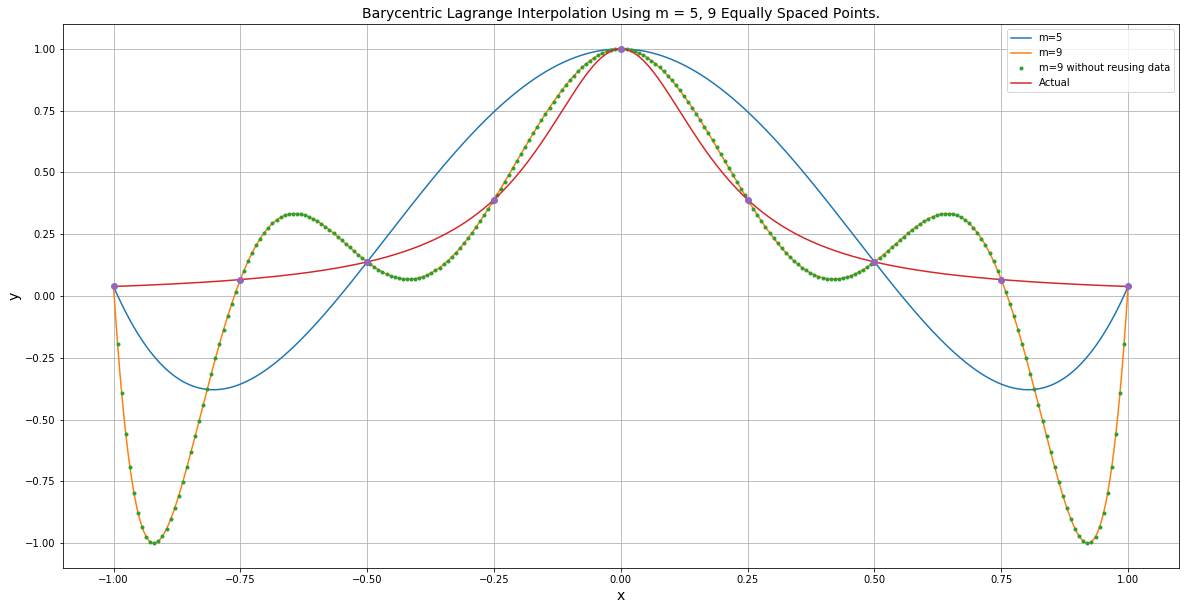

In [8]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,1000)

m = 5
x5vals = np.linspace(-1,1,m)
y5vals = f(x5vals)
m5, old_data_m5 = p_Barycentric_reuse(x5vals,y5vals,x)
print("Data which can be re-used from m =",m)
print(old_data_m5)
print()

m = 9
x9vals = np.linspace(-1,1,m)
y9vals = f(x9vals)
m9, old_data_m9 = p_Barycentric_reuse(x9vals,y9vals,x,old_data_m5)
print("Data which can be re-used from m =",m)
print(old_data_m9)
x1 = np.linspace(-1,1,250)
m9_2 = p_Barycentric(x9vals,y9vals,x1)

plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation Using m = 5, 9 Equally Spaced Points.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,m5)
plt.plot(x,m9)
plt.plot(x1,m9_2, ".")
plt.plot(x,f(x))
plt.plot(x9vals,y9vals, "o")
plt.legend(["m=5","m=9","m=9 without reusing data","Actual"])
plt.grid()

## Problem 4

### Scipy's Barycentric Interpolator (Results compared to those attained for Problem 1)

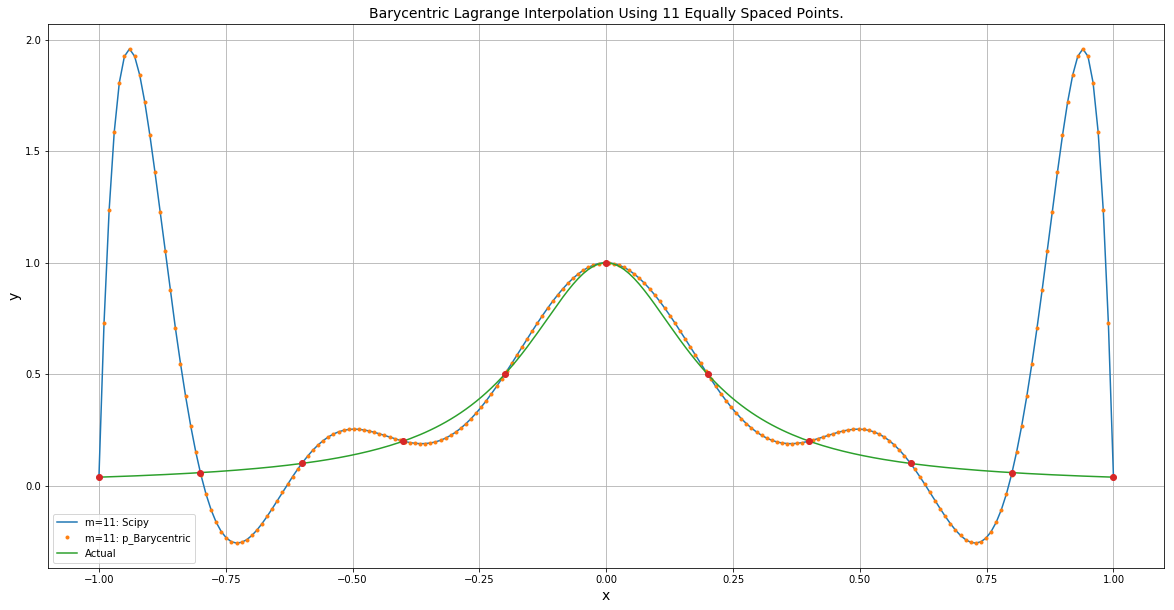

In [9]:
from scipy.interpolate import BarycentricInterpolator
f = lambda x: 1/(1+25 * x**2) # Function to be interpolated.
# Obtain the Chebyshev extremal points on [-1,1].
n = 11
pts = np.linspace(-1, 1, n)
domain = np.linspace(-1, 1, 200)
poly = BarycentricInterpolator(pts[:-1])
poly.add_xi(np.array([pts[-1]])) # Oops, forgot one of the points.
poly.set_yi(f(pts)) # Set the y values.
plt.figure(figsize=(20,10))
plt.plot(domain, poly.__call__(domain))
plt.plot(domain, p_Barycentric(pts,f(pts),domain),'.')
plt.plot(domain, f(domain))
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.title("Barycentric Lagrange Interpolation Using 11 Equally Spaced Points.", fontsize = 14)
plt.plot(pts,f(pts), "o")
plt.legend(["m=11: Scipy","m=11: p_Barycentric","Actual"])
plt.grid()

### Function to generate either Equispaced or Chebyshev interpolating points (will be used in the remaining questions)

In [10]:
def chebspace(N,m=-1,M=1,Zero=False): #Returns N Chebyshev Extremum (Default) or Zero points in the specified interval (Default is [-1,1]).
    r = (m + M)/2
    if (Zero == True):
        pts = np.cos((np.array(range(N,0,-1)) - 0.5)*np.pi/N)
    else:
        pts = np.cos(np.array(range(N-1,-1,-1))*np.pi/(N-1))
    return (pts*(M - r) + r)

### Error and Runtime functions

In [11]:
def InterpolErr(f,n,x_N = 200,lin=False): #Default: 200 point domain and use Cheb nodes.
    if lin == True:
        xvals = np.linspace(-1,1,2**n + 1)
    else:
        xvals = chebspace(2**n + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    poly = BarycentricInterpolator(xvals,yvals)
    return np.linalg.norm((p_Lagrange(xvals,yvals,x) - y), ord=np.inf), np.linalg.norm((p_Barycentric(xvals,yvals,x) - y), ord=np.inf), np.linalg.norm((poly.__call__(x) - y), ord=np.inf)

def InterpolTime(f,n,x_N = 200,lin=False, trials = 100): #Default: 200 point domain, use Cheb nodes, and perform 100 time trials.
    if lin == True:
        xvals = np.linspace(-1,1,2**n + 1)
    else:
        xvals = chebspace(2**n + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    avg1,avg2,avg3 = 0,0,0
    for jj in range(0,trials):
        start_time = time.time()
        p_Lagrange(xvals,yvals,x)
        end_time = time.time()
        avg1+=(end_time-start_time)
        
        start_time = time.time()
        p_Barycentric(xvals,yvals,x)
        end_time = time.time()
        avg2+=(end_time-start_time)
        
        start_time = time.time()
        poly = BarycentricInterpolator(xvals,yvals)
        poly.__call__(x) - y
        end_time = time.time()
        avg3+=(end_time-start_time)
    return avg1/trials, avg2/trials, avg3/trials

### Error measurements

In [12]:
n = 7 #Use 2^n + 1 nodes.
f = lambda x: 1/(1+25 * x**2)

LErr, BErr, ScBErr = InterpolErr(f,n)
print("Norm-inf Error of Lagrange Interpolation")
print(LErr)
print("Norm-inf Error of Barycentric Interpolation")
print(BErr)
print("Norm-inf Error of Scipy's Barycentric Interpolation")
print(ScBErr)

Norm-inf Error of Lagrange Interpolation
8.558431741079175e-12
Norm-inf Error of Barycentric Interpolation
8.558320718776713e-12
Norm-inf Error of Scipy's Barycentric Interpolation
8.558320718776713e-12


The errors are about the same for all three.

### Runtime measurements 1: Recalculate every weight each time

In [13]:
n = 5 #Use 2^n +1 nodes; be careful, using toomany nodes may result in overflow.
f = lambda x: 1/(1+25 * x**2)

LTime, BTime, ScBTime = InterpolTime(f,n)
print("Runtime of Lagrange Interpolation")
print(LTime)
print()
print("Runtime of Barycentric Interpolation")
print(BTime)
print()
print("Runtime of Scipy's Barycentric Interpolation")
print(ScBTime)

Runtime of Lagrange Interpolation
0.0053077077865600585

Runtime of Barycentric Interpolation
0.0016443777084350587

Runtime of Scipy's Barycentric Interpolation
0.0004367208480834961


Scipy's Barycentric Interpolation is the fastest followed by p_Barycentric followed by p_Lagrange.

### Runtime measurements 2: All weights precalculated

In [14]:
def InterpolTime_reuseW(f,n,x_N = 200,lin=False, trials = 100): #Default: 200 point domain, use Cheb nodes, and perform 100 time trials.
    if lin == True:
        xvals = np.linspace(-1,1,2**n + 1)
    else:
        xvals = chebspace(2**n + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    u, OldData = p_Barycentric_reuse(xvals,yvals,x)
    poly = BarycentricInterpolator(xvals,yvals)
    avg1,avg2,avg3 = 0,0,0
    for jj in range(0,trials):
        start_time = time.time()
        p_Lagrange(xvals,yvals,x)
        end_time = time.time()
        avg1+=(end_time-start_time)
        
        start_time = time.time()
        p_Barycentric_reuse(xvals,yvals,x,OldData)
        end_time = time.time()
        avg2+=(end_time-start_time)
        
        start_time = time.time()
        poly.__call__(x) - y
        end_time = time.time()
        avg3+=(end_time-start_time)
    return avg1/trials, avg2/trials, avg3/trials

In [15]:
n = 5 #Use 2^n + 1 nodes.
f = lambda x: 1/(1+25 * x**2)

LTime2, BTime2, ScBTime2 = InterpolTime_reuseW(f,n)
print("Runtime of Lagrange Interpolation")
print(LTime2)
print("Percentage change from measurement 1 =", (LTime2 - LTime)*100/LTime)
print()
print("Runtime of Barycentric Interpolation")
print(BTime2)
print("Percentage change from measurement 1 =", (BTime2 - BTime)*100/BTime)
print()
print("Runtime of Scipy's Barycentric Interpolation")
print(ScBTime2)
print("Percentage change from measurement 1 =", (ScBTime2 - ScBTime)*100/ScBTime)

Runtime of Lagrange Interpolation
0.0056976103782653805
Percentage change from measurement 1 = 7.345969435103719

Runtime of Barycentric Interpolation
0.0009134864807128906
Percentage change from measurement 1 = -44.44789198813401

Runtime of Scipy's Barycentric Interpolation
9.992122650146485e-05
Percentage change from measurement 1 = -77.12011530020636


Both Scipy's Barycentric Interpolation and p_Barycentric are now significantly faster.

### Runtime measurements 3: Half of the weights precalculated

In [16]:
def InterpolTime_reusehW(f,n,x_N = 200,lin=False, trials = 100): #Default: 200 point domain, use Cheb nodes, and perform 100 time trials.
    if lin == True:
        xvals, xvals2 = np.linspace(-1,1,2**n + 1), np.linspace(-1,1,2**(n-1) + 1)
    else:
        xvals, xvals2 = chebspace(2**n + 1), chebspace(2**(n-1) + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    u, OldData = p_Barycentric_reuse(xvals2,f(xvals2),x)
    poly = BarycentricInterpolator(xvals2)
    u1,u2,cup = np.intersect1d(xvals2,xvals,assume_unique=True,return_indices=True) #Note that numpy-1.16.2 is needed for "return_indices" to work.
    xvals_new = np.delete(xvals,cup)
    avg1,avg2,avg3 = 0,0,0
    for jj in range(0,trials):
        start_time = time.time()
        p_Lagrange(xvals,yvals,x)
        end_time = time.time()
        avg1+=(end_time-start_time)
        
        start_time = time.time()
        p_Barycentric_reuse(xvals,yvals,x,OldData)
        end_time = time.time()
        avg2+=(end_time-start_time)
        
        start_time = time.time()
        poly.add_xi(xvals_new)
        poly.set_yi(yvals)
        poly.__call__(x) - y
        end_time = time.time()
        poly = BarycentricInterpolator(xvals2)
        avg3+=(end_time-start_time)
    return avg1/trials, avg2/trials, avg3/trials

In [17]:
n = 5 #Use 2^n + 1 nodes.
f = lambda x: 1/(1+25 * x**2)

LTime3, BTime3, ScBTime3 = InterpolTime_reusehW(f,n)
print("Runtime of Lagrange Interpolation")
print(LTime3)
print("Percentage change from measurement 1 =", (LTime3 - LTime)*100/LTime)
print()
print("Runtime of Barycentric Interpolation")
print(BTime3)
print("Percentage change from measurement 1 =", (BTime3 - BTime)*100/BTime)
print()
print("Runtime of Scipy's Barycentric Interpolation")
print(ScBTime3)
print("Percentage change from measurement 1 =", (ScBTime3 - ScBTime)*100/ScBTime)

Runtime of Lagrange Interpolation
0.005415573120117188
Percentage change from measurement 1 = 2.032239488207342

Runtime of Barycentric Interpolation
0.0010576748847961426
Percentage change from measurement 1 = -35.67932237401081

Runtime of Scipy's Barycentric Interpolation
0.00016916275024414062
Percentage change from measurement 1 = -61.26524506753142


Naturally, Scipy's Barycentric Interpolation and p_Barycentric are now slower than when all the weights were precalculated, however, they are still significantly faster than when every weight was recalculated each time.

## Problem 5

In [18]:
def InterpolErr_ScB(f,n,x_N = 400,lin=False): #Default: 400 point domain and use Cheb extremal nodes.
    if lin == True:
        xvals = np.linspace(-1,1,2**n)
    else:
        xvals = chebspace(2**n)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    poly = BarycentricInterpolator(xvals,yvals)
    return np.linalg.norm((poly.__call__(x) - y), ord=np.inf)

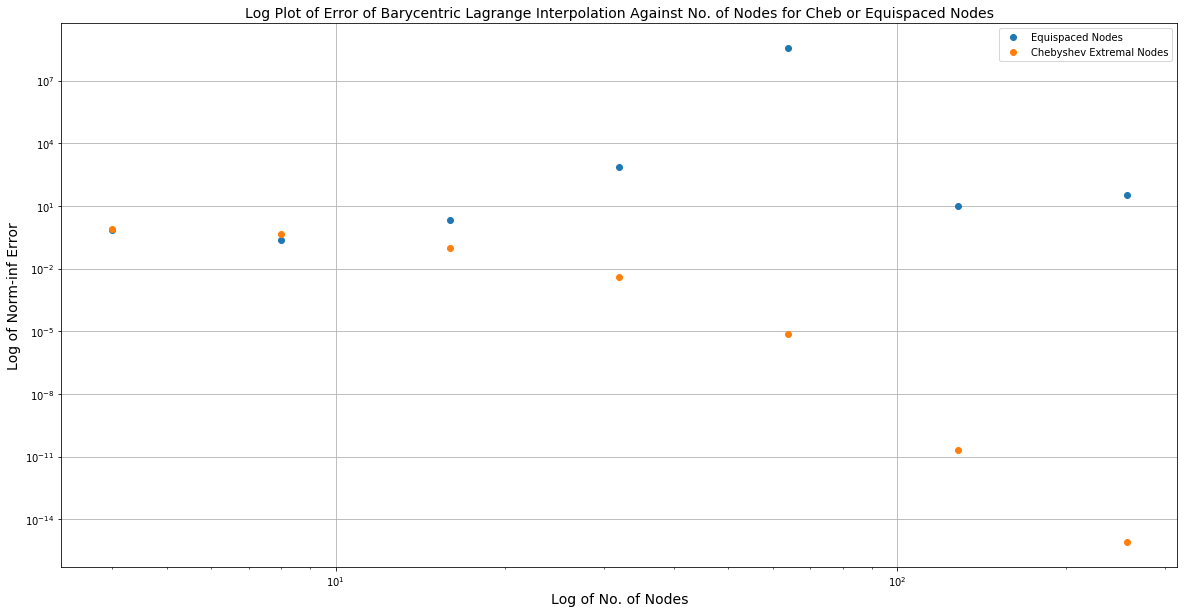

In [19]:
Mx = 8
Mn = 2
f = lambda x: 1/(1+25 * x**2)
linval = np.empty(Mx - Mn + 1)
chebval = np.empty(Mx - Mn + 1)
x = np.empty(Mx - Mn + 1)

for n in rangeE(Mn,Mx): #Use 2^n nodes.
    linval[n-2] = InterpolErr_ScB(f,n,lin=True)
    chebval[n-2] = InterpolErr_ScB(f,n,lin=False)
    x[n-2] = 2**n

plt.figure(figsize=(20,10))
plt.loglog(x, linval, 'o')
plt.loglog(x, chebval, 'o')
plt.xlabel("Log of No. of Nodes", fontsize = 14)
plt.ylabel("Log of Norm-inf Error", fontsize = 14)
plt.title("Log Plot of Error of Barycentric Lagrange Interpolation Against No. of Nodes for Cheb or Equispaced Nodes", fontsize = 14)
plt.legend(["Equispaced Nodes","Chebyshev Extremal Nodes"])
plt.grid()

Only for Chebyshev nodes does the error of the interpolation decreases as the number of nodes increases. When equispaced nodes are used, the error may actually increase when the number of nodes is increased.

### Function Plots

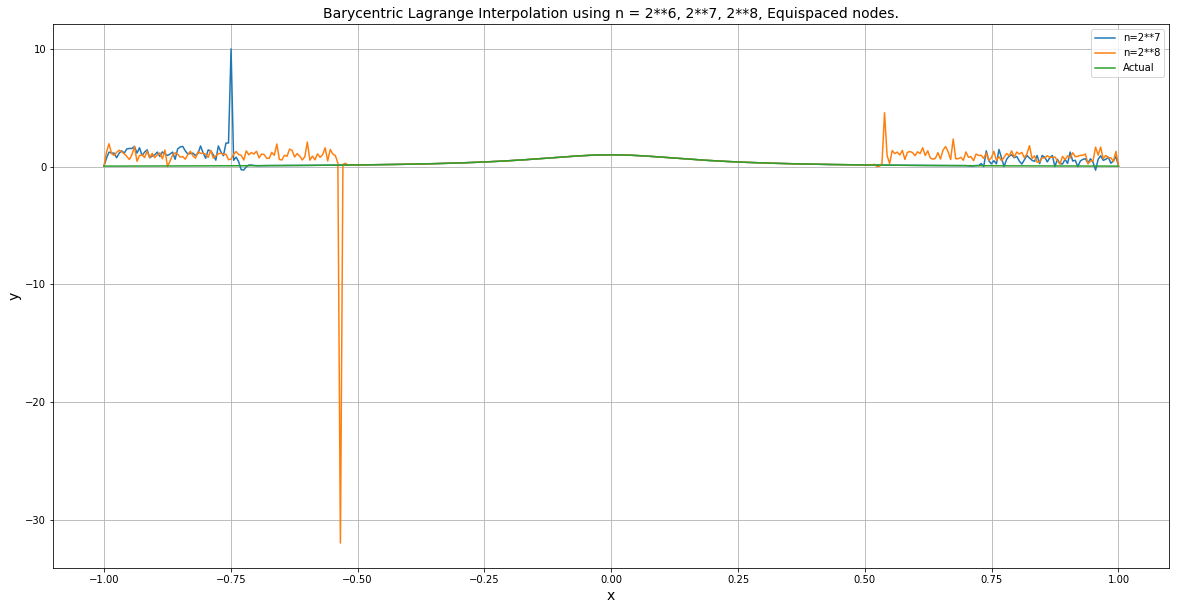

In [20]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,400)

n = 6
x6lin = np.linspace(-1,1,2**n)
x6cheb = chebspace(2**n)

n = 7
x7lin = np.linspace(-1,1,2**n)
x7cheb = chebspace(2**n)

n = 8
x8lin = np.linspace(-1,1,2**n)
x8cheb = chebspace(2**n)

plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation using n = 2**6, 2**7, 2**8, Equispaced nodes.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
#plt.plot(x,BarycentricInterpolator(x6lin,f(x6lin)).__call__(x)) #The error for n = 2**6 is too atrociously bad.
plt.plot(x,BarycentricInterpolator(x7lin,f(x7lin)).__call__(x))
plt.plot(x,BarycentricInterpolator(x8lin,f(x8lin)).__call__(x))
plt.plot(x,f(x))
plt.legend(["n=2**7","n=2**8","Actual"])
plt.grid()
#Looking at the graphs, it is certainly believable that the error is in the hundreds.

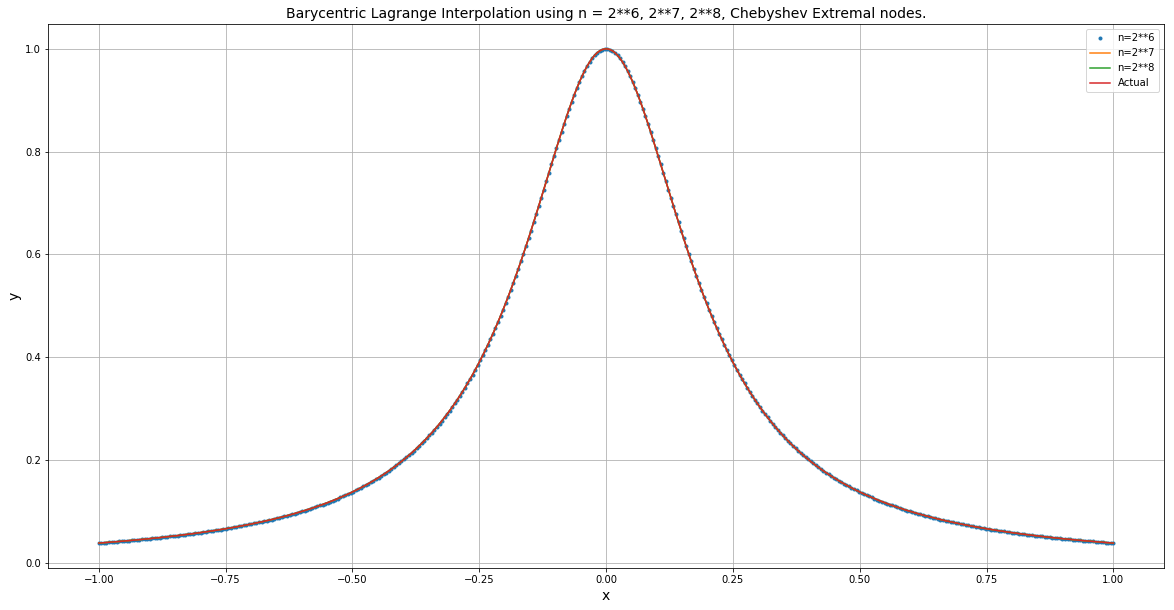

In [21]:
plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation using n = 2**6, 2**7, 2**8, Chebyshev Extremal nodes.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,BarycentricInterpolator(x6cheb,f(x6cheb)).__call__(x),".")
plt.plot(x,BarycentricInterpolator(x7cheb,f(x7cheb)).__call__(x))
plt.plot(x,BarycentricInterpolator(x8cheb,f(x8cheb)).__call__(x))
plt.plot(x,f(x))
plt.legend(["n=2**6","n=2**7","n=2**8","Actual"])
plt.grid()
#The interpolations are almost perfect!

## Problem 6

In [22]:
def Cheb(f,n):
    y = chebspace(n+1)
    farray = f(y)
    fstack = np.hstack([farray,farray[-2:0:-1]])
    ans = np.real(np.fft.fft(fstack)/(n))[0:n+1]*(-1)**np.array(range(0,n+1))
    ans[0] = ans[0]/2
    ans[n] = ans[n]/2
    return ans

### Validation of Cheb function with the function np.polynomial.chebyshev.poly2cheb

In [23]:
size = np.random.randint(2,12)

pcoeffs = np.random.rand(2**size)
ccoeffs = np.polynomial.chebyshev.poly2cheb(pcoeffs)
def f(x):
    ans = 0
    for ii in rangeE(0,2**size-1): 
        ans += pcoeffs[ii]*x**ii
    return ans
np.allclose(Cheb(f,2**size-1),ccoeffs)

True

## Problem 7

In [36]:
def Bweights(xvals):
    n = xvals.size
    value = np.empty(n) #Initialising an array as np.empty is faster.
    C = (np.max(xvals) - np.min(xvals)) / 4
    shuffle = np.random.permutation(n-1)
    for ii in range(0,n):
        temp = (xvals[ii] - np.delete(xvals, ii)) / C
        temp = temp[shuffle]
        value[ii] = 1/np.product(temp)
    return value
    
def Utah_barycentric(n):
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(a, b, 8784)
    domainplot = np.copy(domain)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    data = np.load("Project 1 Data Files/airdata.npy")
    
    xvals = domain[temp2]
    yvals = data[temp2]
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    numer = np.zeros(8784)
    denom = np.zeros(8784)
    w = Bweights(xvals)
    for jj in range(n-1,0,-1):
        d = (domain - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            domain = np.delete(domain,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    plt.figure(figsize=(20,10))
    plt.title(('%i Node Barycentric Lagrange Interpolation of PM_{2.5} (mg/m^3) in Salt Lake County' %n), fontsize = 14)
    plt.xlabel("Domain", fontsize = 14)
    plt.ylabel("PM_{2.5} (mg/m^3)", fontsize = 14)
    plt.plot(domainplot,data,".")
    plt.plot(domainplot,ans,linewidth=5)
    plt.legend(["Actual Data","Barycentric Interpolation"])
    plt.grid()

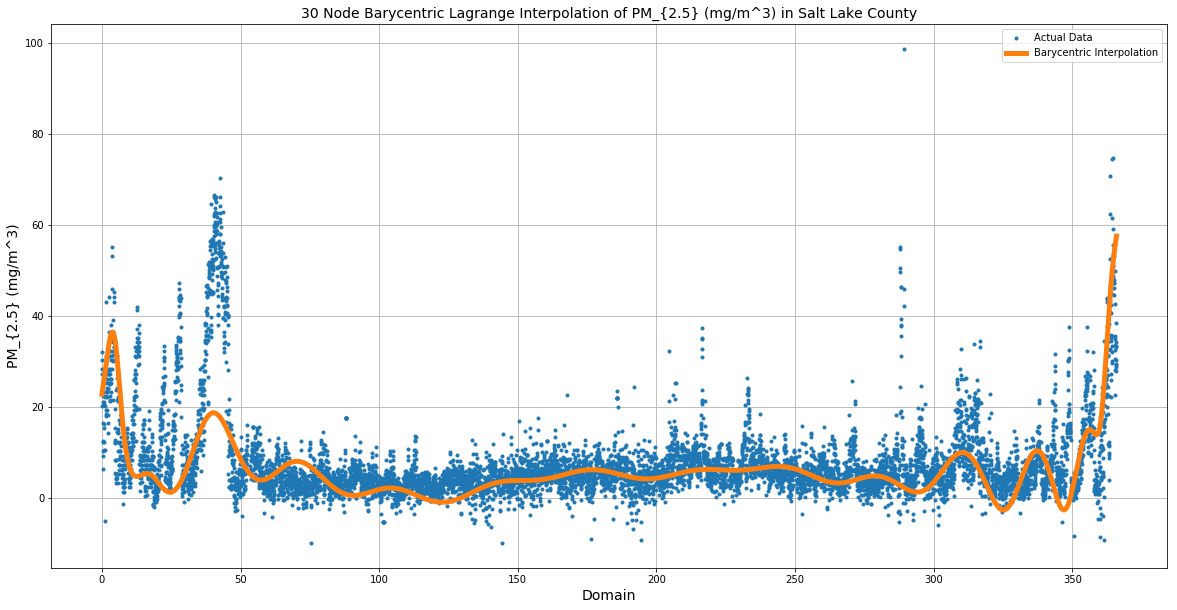

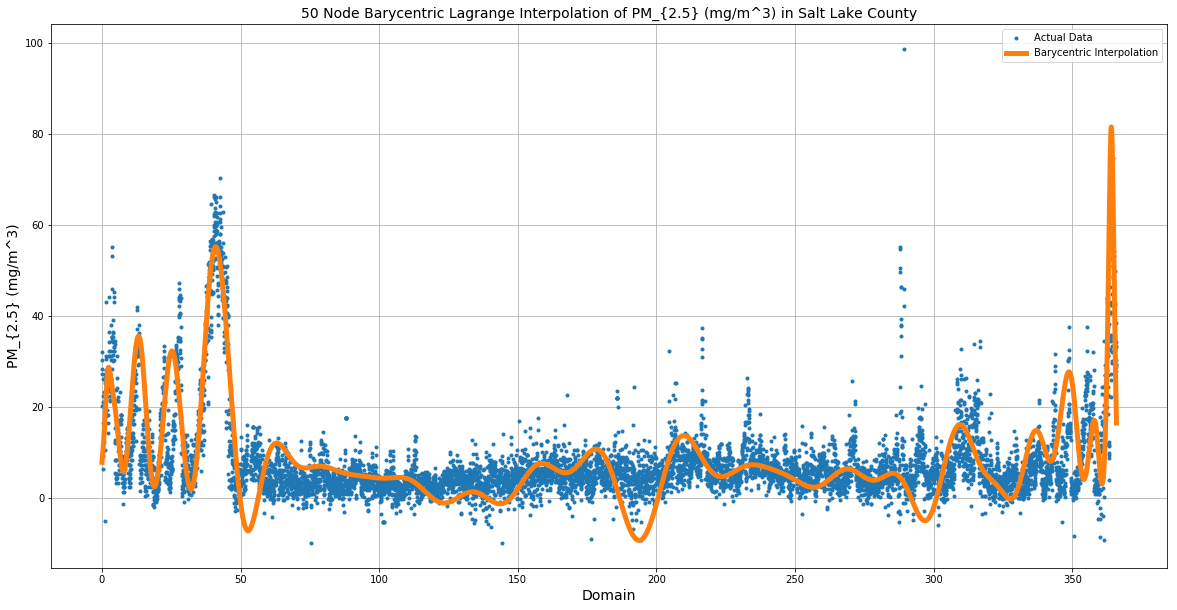

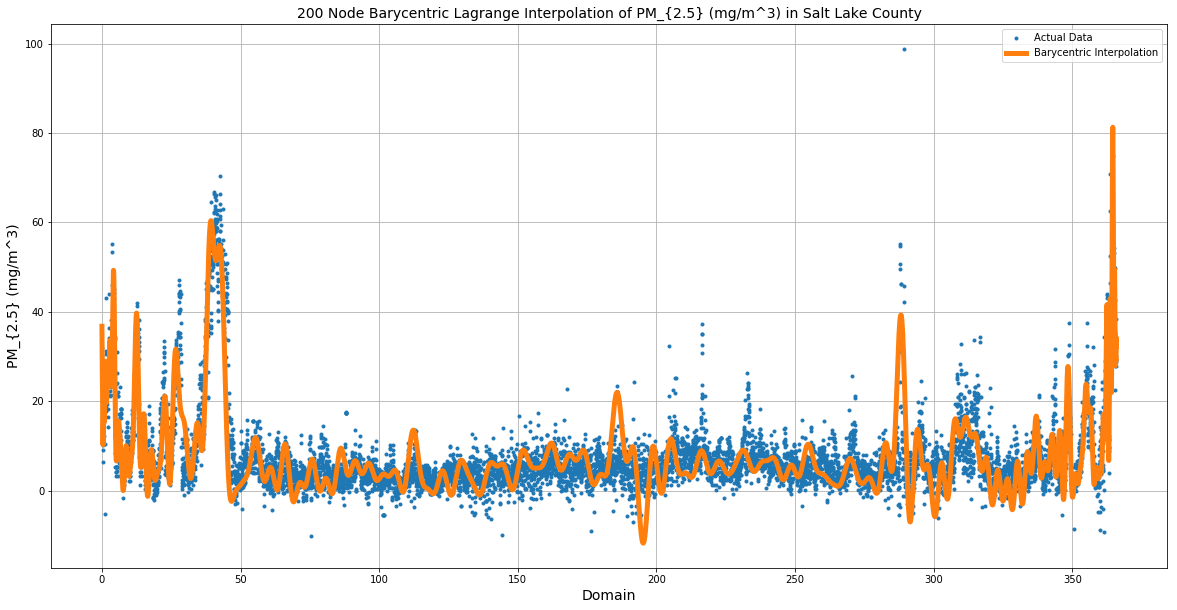

In [37]:
Utah_barycentric(30)
Utah_barycentric(50)
Utah_barycentric(200)

### Bonus: Error plot

In [26]:
def Utah_barycentric_vals(n):
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(a, b, 8784)
    domainplot = np.copy(domain)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    data = np.load("Project 1 Data Files/airdata.npy")
    
    xvals = domain[temp2]
    yvals = data[temp2]
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    numer = np.zeros(8784)
    denom = np.zeros(8784)
    w = Bweights(xvals)
    for jj in range(n-1,0,-1):
        d = (domain - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            domain = np.delete(domain,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    return ans

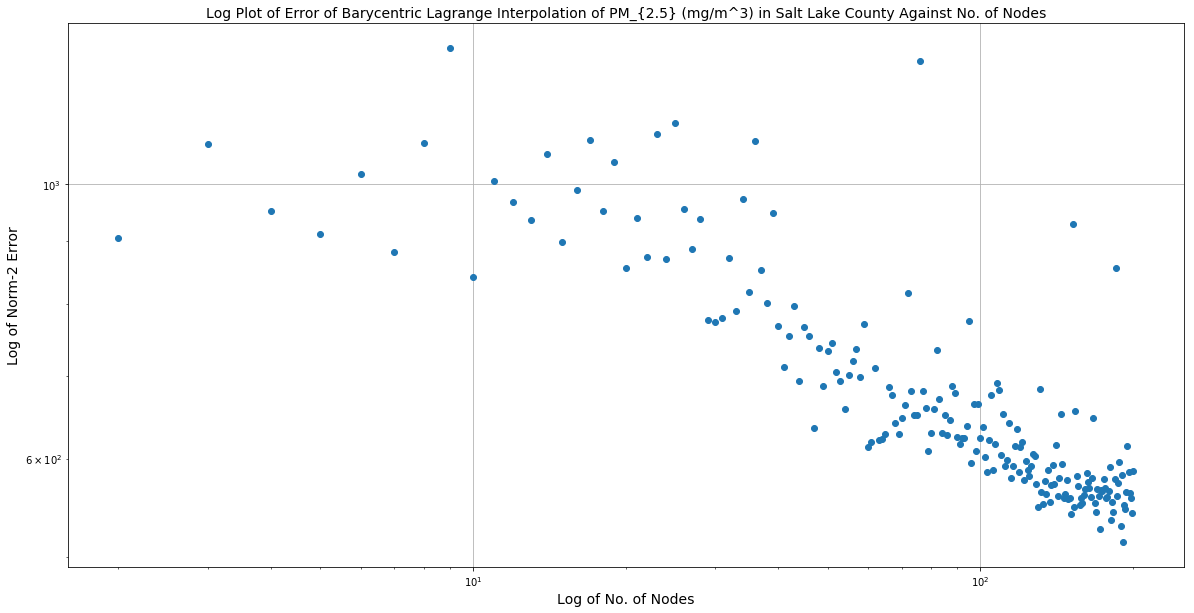

In [27]:
data = np.load("Project 1 Data Files/airdata.npy")
n = 200
Error = np.empty(n-1)
for ii in rangeE(2,n): #May take about half a minute.
    Error[ii-2] = np.linalg.norm((Utah_barycentric_vals(ii) - data), ord=2)

plt.figure(figsize=(20,10))
plt.title('Log Plot of Error of Barycentric Lagrange Interpolation of PM_{2.5} (mg/m^3) in Salt Lake County Against No. of Nodes', fontsize = 14)
plt.xlabel("Log of No. of Nodes", fontsize = 14)
plt.ylabel("Log of Norm-2 Error", fontsize = 14)
plt.loglog(rangeE(2,n),Error,'o')
plt.grid()

The error of the interpolation decreases as the number of nodes increases. Though the decrease is quite messy, the overall pattern is highly reminiscent of the Log Error Plot in Problem 5.

## Problem 8

Conditions:
$f$ is twice integrable, and $\alpha = \beta$, i.e. $u'$ is periodic.

## Problem 9

### Plot of Data Points:

Text(0.5, 1.0, 'Plot of Data Points')

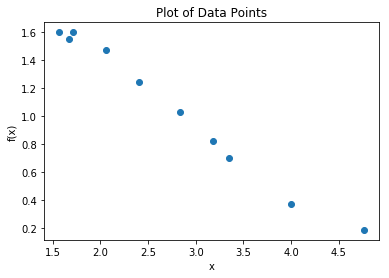

In [28]:
data = np.load("Project 1 Data Files/heatdata.npy")
xvals = data[0,:]
fvals = data[1,:]
plt.plot(xvals,fvals,'o')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Plot of Data Points")

Using results from Q3 of Homework 3, we will cast the problem into the form $A\vec{U} = \vec{G}$ using the finite difference formula,
$$u''(x) = \frac{1}{h^2}u(x-h) - \frac{2}{h^2}u(x) + \frac{1}{h^2}u(x+h).$$

$$\therefore A = \frac{1}{h^2}\left(
\begin{array}{ccccccccc}
-2 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 1 & -2 & 1 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 1 & -2
 \end{array} \right) \hspace{2pc}
 \vec{U} = \left(
 \begin{array}{c}
 u(x_1) \\
 u(x_2) \\
 \vdots \\
 u(x_n)
 \end{array} \right) \hspace{2pc}
 \vec{G} = \left(
 \begin{array}{c}
 u''(x_1) - \displaystyle \frac{1}{h^2}u(x_0) \\
 u''(x_2) \\
 \vdots \\
 u''(x_{n-1}) \\
 u''(x_n) - \displaystyle \frac{1}{h^2}u(x_{n+1})
 \end{array} \right)$$
 
 We will approximate $u'(x_0) = u'(a) = \alpha$ and $u'(x_{n+1}) = u'(b) = \beta$ using the forward difference and backward difference methods respectively. Therefore, we get
 \begin{align}
 &u'(a) = \frac{u(x_1) - u(a)}{h} \implies u(a) = u(x_1) - hu'(a) \mbox{ and } \\
 &u'(b) = \frac{u(b) - u(x_n)}{h} \implies u(b) = u(x_n) + hu'(b).
 \end{align}
 Therefore, the first and last equations of the linear system $A\vec{U} = \vec{G}$ are respectively
 \begin{align}
 &-2u(x_1) + u(x_2) = u''(x_1) - \frac{1}{h^2}u(a) \\
 &\implies -2u(x_1) + u(x_2) = u''(x_1) - \frac{1}{h^2}(u(x_1) - hu'(a)) \\
 &\implies \left(-2+\frac{1}{h^2}\right)u(x_1) + u(x_2) = u''(x_1) + \frac{1}{h}u'(a) \\
 &\implies \left(-2+\frac{1}{h^2}\right)u(x_1) + u(x_2) = u''(x_1) + \frac{\alpha}{h} \mbox{ and }\\
 &u(x_{n-1}) - 2u(x_n) = u''(x_n) - \frac{1}{h^2}u(b) \\
 &\implies u(x_{n-1}) - 2u(x_n) = u''(x_n) - \frac{1}{h^2}(u(x_n) + hu'(b)) \\
 &\implies u(x_{n-1}) + \left(-2 + \frac{1}{h^2}\right)u(x_n) = u''(x_n) - \frac{1}{h}u'(b). \\
 &\implies u(x_{n-1}) + \left(-2 + \frac{1}{h^2}\right)u(x_n) = u''(x_n) - \frac{\beta}{h}. \\
 \end{align}
 
 Therefore, we get
 $$\therefore A = \frac{1}{h^2}\left(
\begin{array}{ccccccccc}
\displaystyle \left(-2+\frac{1}{h^2}\right) & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 1 & -2 & 1 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 1 & \displaystyle \left(-2 + \frac{1}{h^2}\right)
 \end{array} \right) \hspace{2pc}
 \vec{U} = \left(
 \begin{array}{c}
 u(x_1) \\
 u(x_2) \\
 \vdots \\
 u(x_n)
 \end{array} \right) \hspace{2pc}
 \vec{G} = \left(
 \begin{array}{c}
 \displaystyle u''(x_1) + \frac{\alpha}{h} \\
 u''(x_2) \\
 \vdots \\
 u''(x_{n-1}) \\
 \displaystyle u''(x_n) - \frac{\beta}{h}
 \end{array} \right)$$

In [29]:
def solve_for_U_NeumannBC_excludeend(xvals,upp,alpha, beta):
    diff = xvals[1]-xvals[0] #diff := x_1 - x_0 = x_{j+1} - x_j.
    n = xvals.size
    h = np.ones(n)*diff
    d0 = -2*(1/h**2)
    d1 = 1/h[1:]**2
    dm1 = 1/h[0:-1]**2
    # create the "A" matrix by using the np.diag command
    A = sp.diags(d0) + sp.diags(d1,1)+ sp.diags(dm1,-1)
    A[0,0], A[-1,-1] = (-2 + 1/diff**2)/diff**2, (-2 + 1/diff**2)/diff**2
    
    # create the "G" matrix by applying the function to x_i.
    uppvals = upp(xvals)
    uppvals[0] = np.copy(uppvals[0]) + alpha/diff
    uppvals[-1] = np.copy(uppvals[-1]) + beta/diff
    # Ax = b, solve for x.
    np.linalg.solve(A,uppvals)
    
    return uvals

The problem we face however, is that the approach above assumes that we have equispaced data points, and hence $h$ is a constant. The graph of data points makes it evident that this is not true. To make up for our data points not being equispaced, we will need to interpolate them.

For the interpolation to be accurate, we need the values at the endpoints, $u(a)$ and $u(b)$. Therefore, we will precalculate those values based on the data we have and add them to our data.

1.4467008528208938


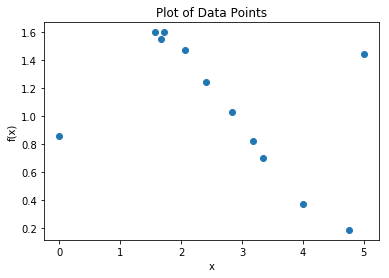

In [30]:
a = 0
b = 5
alpha = 0.416
beta = 5.250

ua = fvals[1] - (xvals[1]-a)*alpha
ub = fvals[-1] + (b-xvals[-1])*beta
xvalsBC = np.hstack([[a],xvals,[b]])
fvalsBC = np.hstack([[ua],fvals,[ub]])
plt.plot(xvalsBC,fvalsBC,'o')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Plot of Data Points")
print(ub)

In [31]:
fvals[-1]

0.18808759575205192

In [32]:
a = 0
b = 5
alpha = 0.416
beta = 5.250
xvalsBC = np.hstack([[a],xvals,[b]])
xvalsBC

array([0.        , 1.57175937, 1.67244421, 1.71445095, 2.06273705,
       2.40461456, 2.83471538, 3.17582029, 3.35200901, 4.00147583,
       4.76026414, 5.        ])

We can just directly interpolate all the points using Scipy's BarycentricInterpolator:

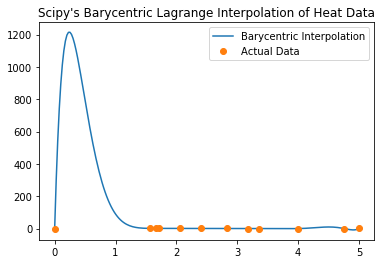

In [33]:
data = np.load("Project 1 Data Files/heatdata.npy")
xvals = data[0,:]
fvals = data[1,:]
x = np.linspace(0,5,200)
plt.title("Scipy's Barycentric Lagrange Interpolation of Heat Data")
poly = BarycentricInterpolator(xvalsBC,fvalsBC)
plt.plot(x,poly.__call__(x))
plt.plot(xvalsBC,fvalsBC,"o")
plt.legend(["Barycentric Interpolation","Actual Data"])

However, the error of the interpolation will be horrendous.